In [1]:
# Import the required dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
# Set all the constants
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 100

In [3]:
# Import data into TensorFlow Dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\AAPMH\\Downloads\\skin-cancer-detection-using-ddi-dataset-main\\skin-cancer-detection-using-ddi-dataset-main\\skin",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 1968 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names 

['benign', 'malignant']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


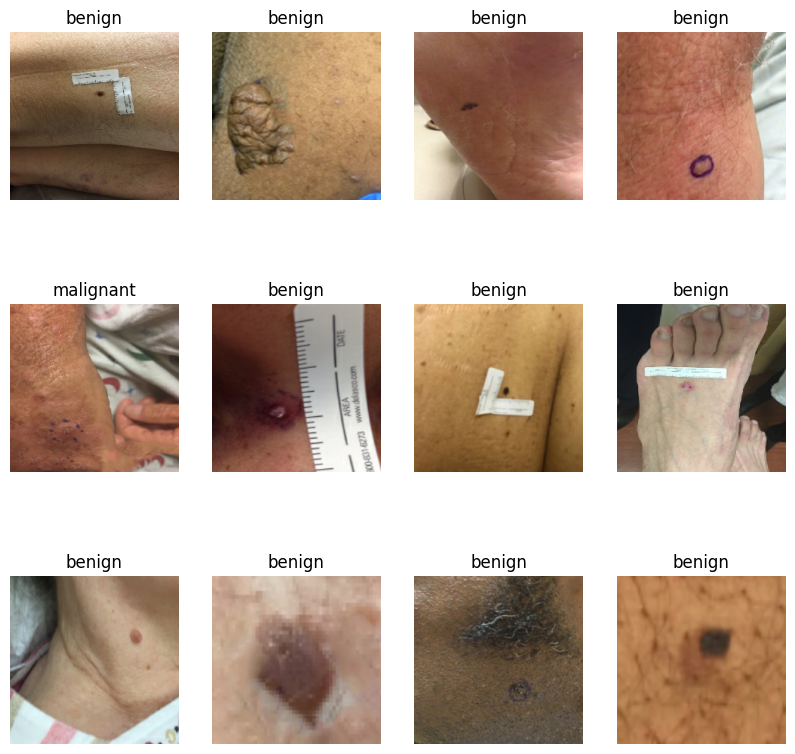

In [6]:
# Visualize some of the images from our dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
# Function to Split Dataset
len(dataset)

62

In [8]:
train_size = 0.8
len(dataset) * train_size

49.6

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

8

In [11]:
val_size = 0.1
len(dataset) * val_size

6.2

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

2

In [14]:
# Function to split the dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

49

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

7

In [19]:
# Cache, shuffle, and prefetch the dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
# Building the Model
# Creating a new Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./244),
])

In [21]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
# Building the AlexNet model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./244, input_shape=input_shape),
    layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)      

In [24]:
# Compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
# Training the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/100
15/49 [========>.....................] - ETA: 54s - loss: 1.6229 - accuracy: 0.6292

In [ ]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 5s 243ms/step - loss: 0.5879 - accuracy: 0.7277


In [ ]:
scores
#Score is just a list containing loss and accuracy value

[0.587887167930603, 0.7276785969734192]

In [ ]:
#Plotting the Accuracy and Loss Curves
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 49}

In [ ]:
history.history.keys()
#loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

100

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9719336032867432,
 0.5607605576515198,
 0.5601029992103577,
 0.5610830783843994,
 0.5602064728736877]

In [ ]:
# Plotting the Accuracy and Loss Curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


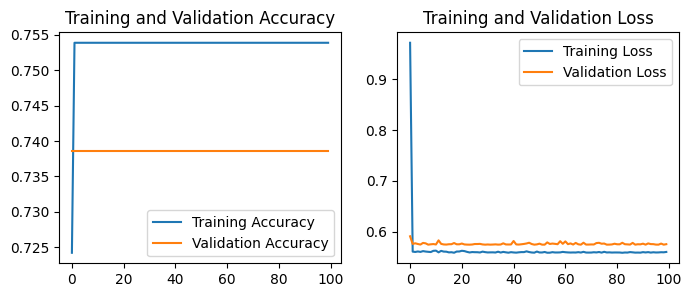

In [ ]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 234ms/step


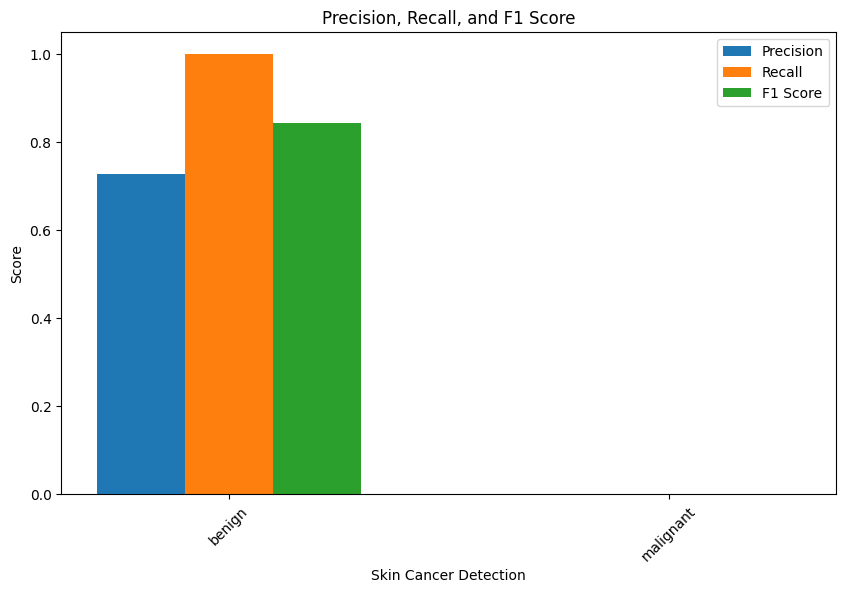

In [ ]:
# Printing Precision, Recall, and F1 Score
test_images = []
test_labels = []
predicted_labels = []

for images_batch, labels_batch in test_ds:
    test_images.extend(images_batch.numpy())
    test_labels.extend(labels_batch.numpy())
    batch_prediction = model.predict(images_batch)
    predicted_labels.extend(np.argmax(batch_prediction, axis=1))

test_labels = np.array(test_labels)
predicted_labels = np.array(predicted_labels)

precision = precision_score(test_labels, predicted_labels, average=None, zero_division=0)
recall = recall_score(test_labels, predicted_labels, average=None)
f1 = f1_score(test_labels, predicted_labels, average=None)

# Plotting the metrics
plt.figure(figsize=(10, 6))
x = np.arange(len(class_names))

plt.bar(x - 0.2, precision, width=0.2, label='Precision')
plt.bar(x, recall, width=0.2, label='Recall')
plt.bar(x + 0.2, f1, width=0.2, label='F1 Score')

plt.xticks(x, class_names, rotation=45)
plt.xlabel('Skin Cancer Detection')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score')
plt.legend()
plt.show()

1/1 [==============================] - 0s 242ms/step


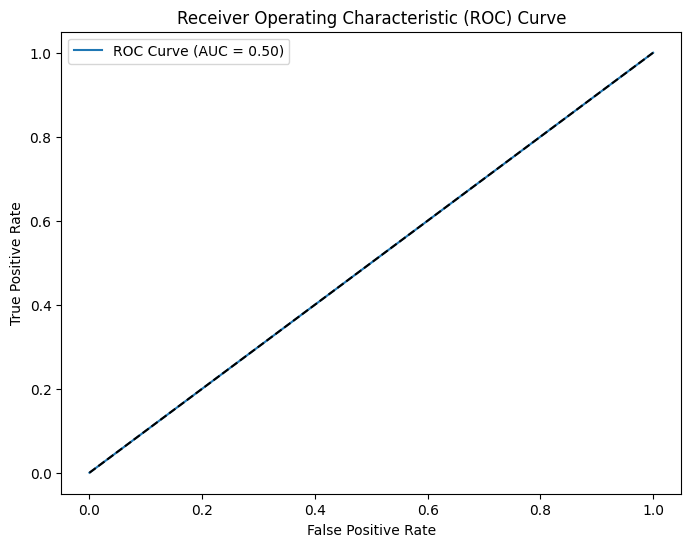

AUC Score: 0.5


In [ ]:
# After evaluating the model on the test set
test_images = []
test_labels = []
predicted_probabilities = []

for images_batch, labels_batch in test_ds:
    test_images.extend(images_batch.numpy())
    test_labels.extend(labels_batch.numpy())
    batch_prediction = model.predict(images_batch)
    predicted_probabilities.extend(batch_prediction)

test_labels = np.array(test_labels)
predicted_probabilities = np.array(predicted_probabilities)

# Calculate the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(test_labels, predicted_probabilities[:, 1])
auc_score = roc_auc_score(test_labels, predicted_probabilities[:, 1])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print the AUC score
print('AUC Score:', auc_score)







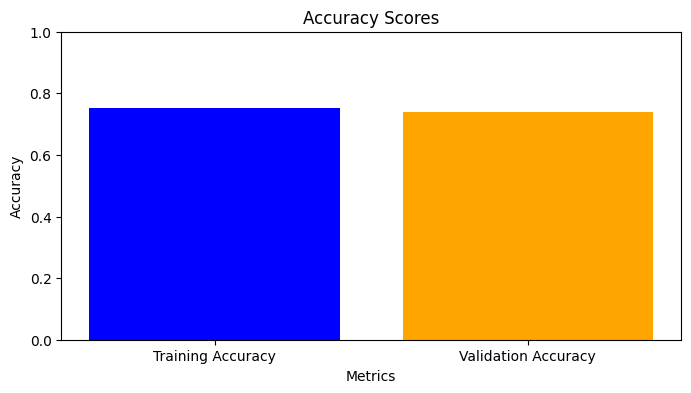

In [ ]:
# Plotting the Accuracy Scores
plt.figure(figsize=(8, 4))
metrics = ["Training Accuracy", "Validation Accuracy"]
accuracy_scores = [acc[-1], val_acc[-1]]

plt.bar(metrics, accuracy_scores, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.xlabel("Metrics")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores")
plt.show()


first image to predict
actual label: benign
1/1 [==============================] - 0s 211ms/step
predicted label: benign


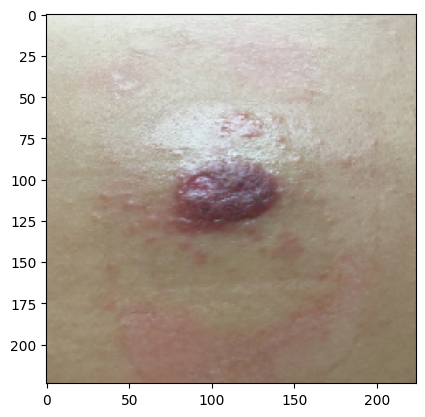

In [ ]:
#Run prediction on a sample image
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
#Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


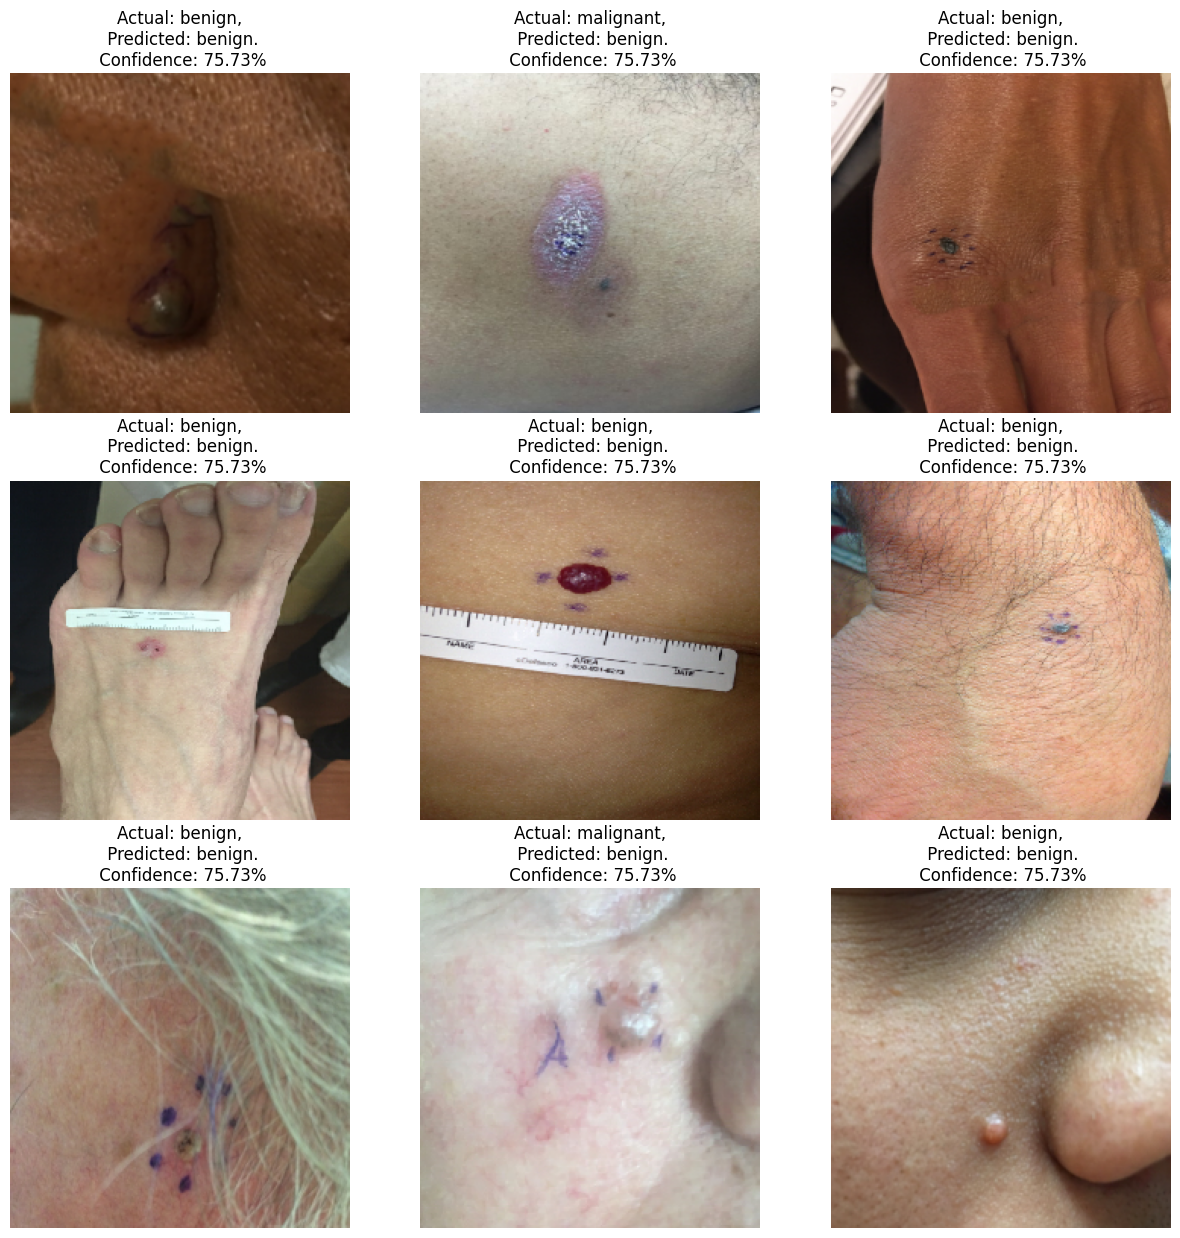

In [ ]:
#Now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
# Saving the model
model.save("skinalexnet56.h5")

c:\Users\AAPMH\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
